In [41]:
from analyze_language_change import Mail, Paper, import_corpus, linear_prediction, occurrence_freq_by_year, occurrences_by_year, plot_word_timeseries
from pydantic import TypeAdapter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import spacy

In [53]:
papers = import_corpus(batch_size=100, streaming=False, url="julilili42/papers", adapter = TypeAdapter(list[Paper]))
rows = [(a.date.year, a.article) for a in papers]
year, articles = zip(*rows)

58419 articles to be loaded for dataset papers


In [ ]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(max_features=100000, binary=True)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0, 0.5, 'Number of articles')

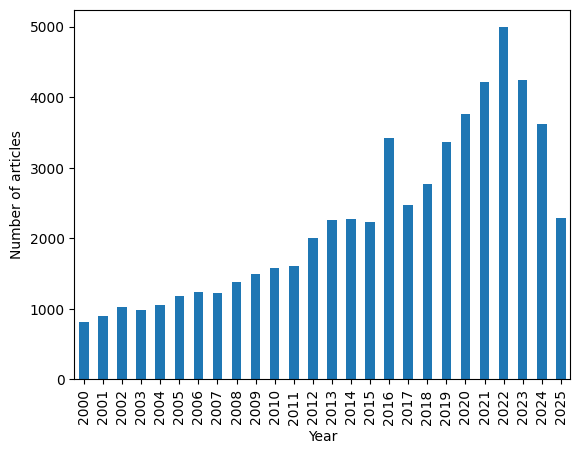

In [46]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of articles")

In [47]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)
occurence_counts = occurrences_by_year(year=year, word_matrix=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [48]:
eps = 1e-6

# dataframe containing frequencies before introduction of llm's
train = occurence_freq.loc[2000:2021]
train_baseline = train.mean()

# empirical frequency
p = occurence_freq.loc[2024] 

# absolute growth from baseline in percent
growth_abs = (p - train_baseline) / (train_baseline + eps)
growth_log = np.log((p + eps) / (train_baseline + eps))

# linear interpolation, frequency value of 2024
q = train.apply(linear_prediction, axis=0)

# Metric 1: frequency gap delta = p - q
delta = p - q

# Metric 2: frequency ratio r = p/q
min_q = 5e-4
min_p = 5e-3
mask = (q > min_q) & (p > min_p)
r = p[mask] / q[mask]

sorted_freq_gap = delta.sort_values(ascending=False).head(20)
sorted_freq_ratio = r.sort_values(ascending=False).head(50)

sorted_freq_mean = growth_log.sort_values(ascending=False).head(20)
sorted_freq_mean

chatgpt                7.817528
pfas                   7.699796
llms                   7.699796
uncrewed               7.699796
birdsong               7.566329
mman                   7.566329
chatbot                7.566329
extratropical          7.566329
teleconnections        7.412264
pmip4                  7.412264
pgi                    7.412264
neoblast               7.412264
neoblasts              7.412264
fgf14                  7.412264
akiti                  7.412264
shapley                7.230064
cloudbursts            7.230064
phosphoribulokinase    7.230064
mac3                   7.230064
coldwaves              7.230064
dtype: float64

In [49]:
metrics = pd.DataFrame({"p": p, "q": q, "growth": growth_log})

metrics["delta"] = metrics["p"] - metrics["q"]
metrics["r"] = metrics["p"] / np.maximum(metrics["q"], eps)

mask_ratio = (metrics["q"] > min_q) & (metrics["p"] > min_p)
excess = metrics.loc[mask_ratio]

In [50]:
import spacy
# german    de_core_news_lg
# english   en_core_web_lg
nlp = spacy.load("en_core_web_lg")

words = list(excess.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess.loc[excess.index.isin(style_words)].sort_values("growth", ascending=False)

In [51]:
excess_style_words

,p,q,growth,delta,r
leveraging,0.011310,0.011022,2.741501,0.000288,1.026167
underscores,0.012690,0.005976,2.669228,0.006714,2.123514
ai,0.015724,0.006292,2.606311,0.009433,2.499251
leverages,0.005241,0.001706,2.502470,0.003535,3.071605
underscore,0.009931,0.005193,2.179334,0.004738,1.912493
...,...,...,...,...,...
give,0.013517,0.024905,-0.802870,-0.011388,0.542746
describes,0.005517,0.012334,-0.816444,-0.006817,0.447312
seems,0.009655,0.017087,-0.886624,-0.007431,0.565076
hope,0.005241,0.055830,-0.935563,-0.050588,0.093882


In [ ]:
llm_words_en = {
    "however", "therefore", "thus", "moreover", "furthermore", "additionally",
    "consequently", "hence", "overall", "notably", "significantly", "indeed",
    "particularly", "specifically", "typically", "generally", "commonly",
    "frequently", "importantly", "essentially", "fundamentally", "crucially",
    "ultimately", "accordingly", "meanwhile", "subsequently", "nevertheless",
    "nonetheless", "similarly", "likewise", "additionally", 
    "arguably", "notably", "remarkably", "clearly", "evidently", "apparently",
    "presumably", "undoubtedly", "likely", "probably", "potentially",
    "essential", "necessary", "relevant", "important", "key", "central",
    "crucial", "significant", "primary", "major", "critical", "noteworthy",
    "overall", "eventually", "ultimately", "consequently", "henceforth",
    "simultaneously", "meanwhile", "previously", "subsequently", "formerly", 
    "currently", "nowadays",
}

found_llm_words = [w for w in llm_words_en if w in excess.index]

llm_in_df = excess.loc[excess.index.isin(found_llm_words)]

llm_in_df.sort_values("growth", ascending=False)

,p,q,growth,delta,r
crucially,0.009103,0.004125,1.556110,0.004978,2.206894
notably,0.028138,0.020424,1.334057,0.007714,1.377721
crucial,0.071724,0.048565,0.994352,0.023159,1.476863
additionally,0.069241,0.039850,0.936769,0.029391,1.737529
nonetheless,0.006069,0.008666,0.932297,-0.002597,0.700350
potentially,0.044138,0.035740,0.910320,0.008398,1.234964
ultimately,0.011862,0.049876,0.827758,-0.038014,0.237831
overall,0.099034,0.105211,0.669319,-0.006176,0.941295
specifically,0.047172,0.037729,0.659979,0.009443,1.250281
key,0.083310,0.079398,0.608563,0.003912,1.049273


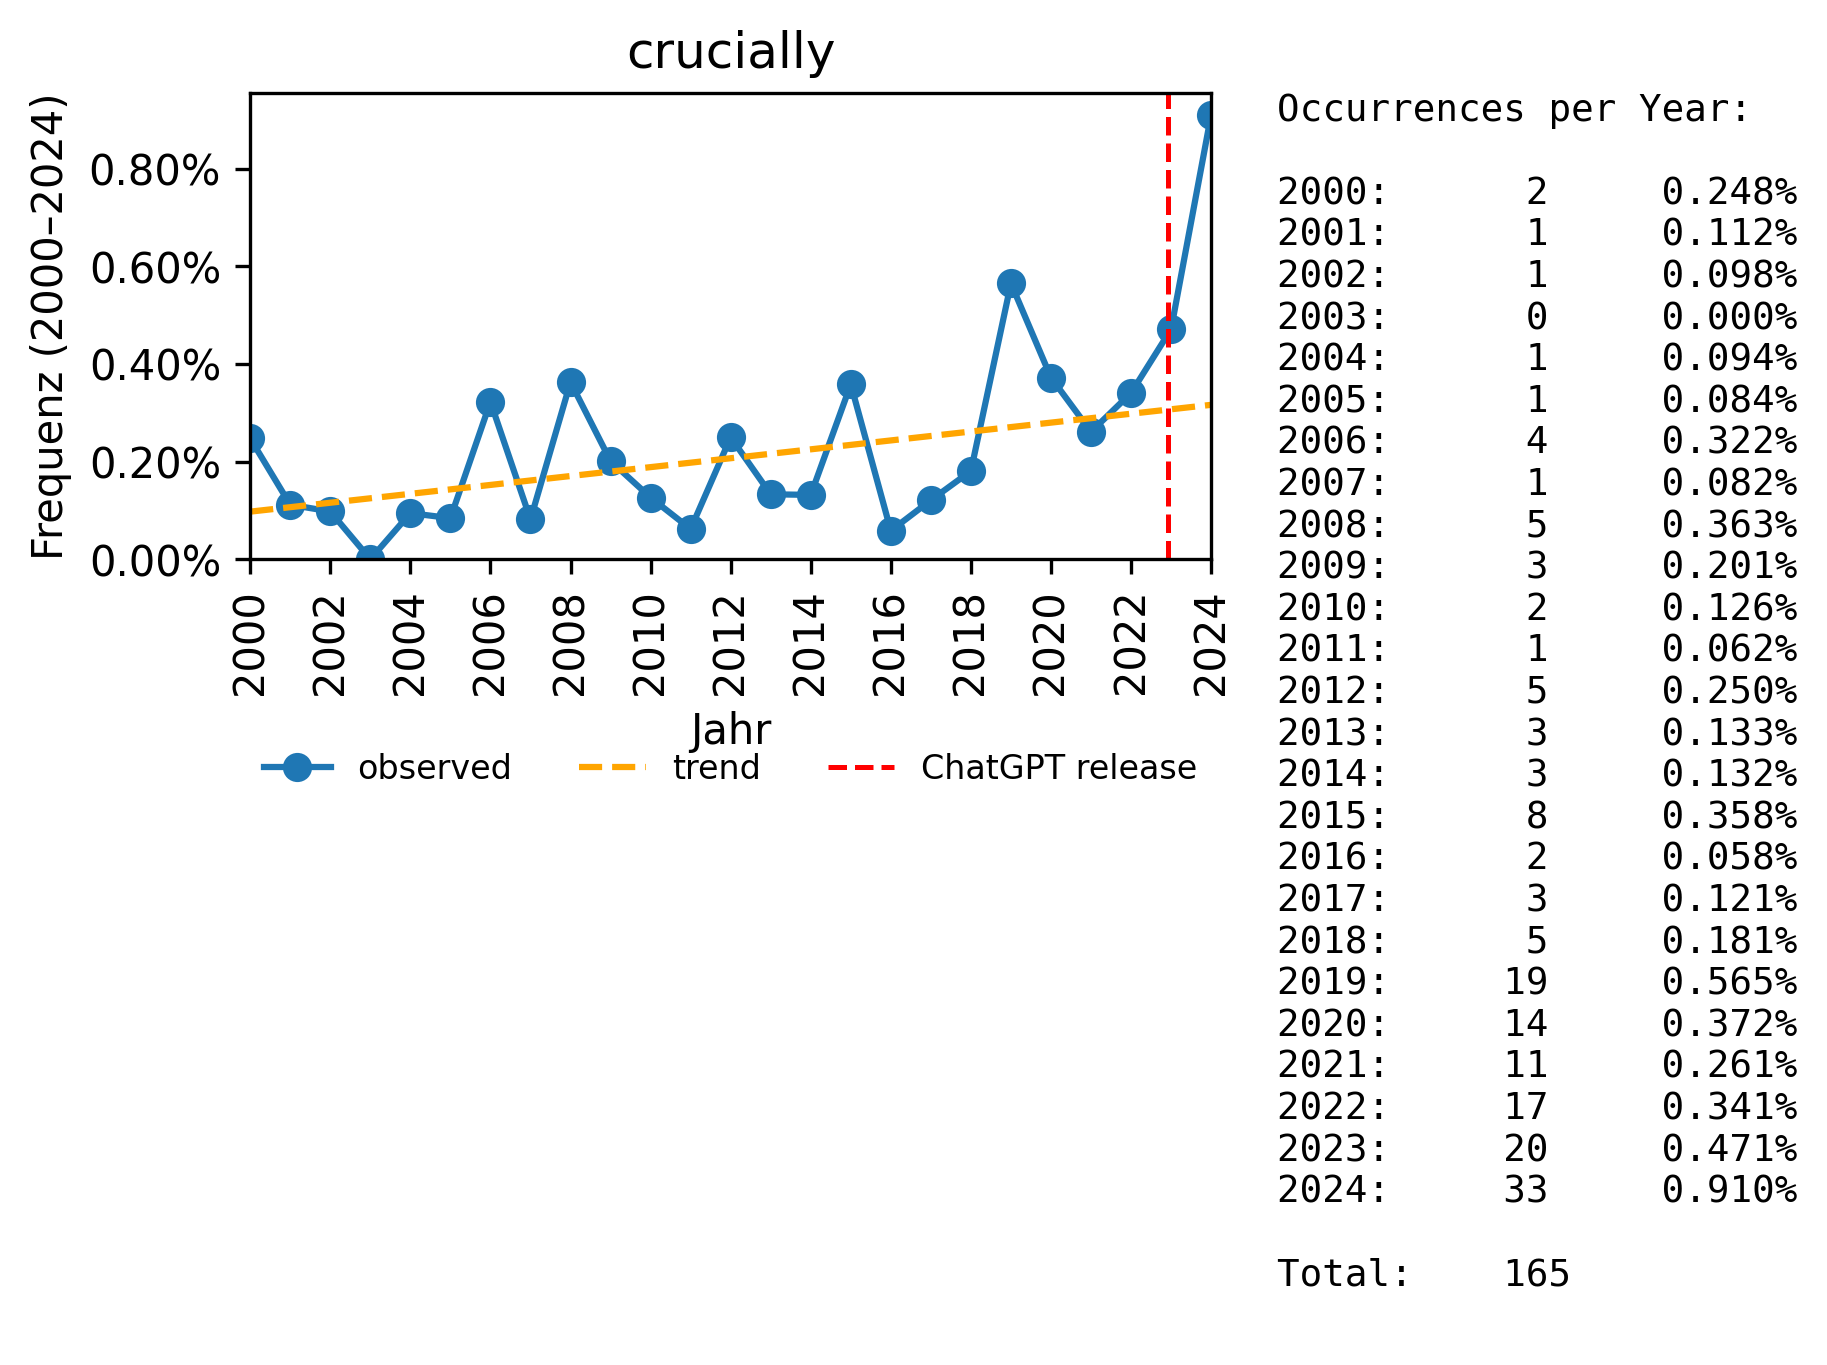

{'p': 0.00910344827586207,
 'q': 0.004311711440598083,
 'delta': 0.004791736835263986}

In [58]:
plot_word_timeseries(
  word="crucially", 
  occurence_freq=occurence_freq,
  occurrences_abs=occurence_counts,
  year_range=(2000, 2024),
  train_years=(2000, 2020),  #needs to adapted depending on corpus
  target_year=2024
)